In [2]:
import numpy as np
import matplotlib.pyplot as plt

from svm import SVM

In [3]:
def wrap_around(i, size):
    """Helper function, to wrap indicies around a grid. Only works for square matrices."""
    return i % size


def flatten(a):
    """Flatten a n dimensional array into a n-1 dimensional array."""
    return a.reshape(-1, a.shape[-1])


def lookup(grid, location):
    """Helper function to look up a value in a given grid. Takes an array with an x and y coordinate."""
    return grid[tuple(location)]


def find_spaces(grid, value):
    """Helper function to find indices of a specific value."""
    return np.argwhere(grid == value)


def adjacent(space):
    """Calculates the indices of the adjacent spaces"""
    return flatten(np.array([space + np.array(adj) for adj in [[-1, 0], [0, 1], [1, 0], [0, -1]]]))


def find_adjacent(spaces, grid_size):
    """For a list of spaces, find all adjacent, and wrap around the grid."""
    return np.array([wrap_around(adjacent(space), grid_size) for space in spaces])


def check_availability(spaces, grid):
    return np.array([space for space in spaces if lookup(grid, space) == 0])


def get_subgrid(grid, origin, size=(7, 7)):
    x_size, y_size = grid.shape
    x_origin, y_origin = origin

    x_offset = int(size[0] / 2 if size[0] % 2 == 0 else (size[0] - 1) / 2)
    y_offset = int(size[1] / 2 if size[1] % 2 == 0 else (size[1] - 1) / 2)
    
    x_indices = wrap_around(np.arange(x_origin - x_offset, x_origin + x_offset + 1, dtype='int8'), x_size)
    y_indices = wrap_around(np.arange(y_origin - y_offset, y_origin + y_offset + 1, dtype='int8'), y_size)
    
    subgrid = np.zeros(size, dtype='int8')
    index_grid = np.zeros((size[0], size[1], 2), dtype='int8')

    for i, x in enumerate(x_indices):
        for j, y in enumerate(y_indices):
            subgrid[i, j] = grid[x, y]
            index_grid[i, j] = np.array([x, y])

    return subgrid, index_grid

In [4]:
x_row = np.load('data/random_complete.npy')
x_random = np.load('data/row_complete.npy')

x = np.append(x_row, x_random, axis=0).reshape(900, 49)
y = np.append(np.ones(450) * -1, np.ones(450))

print(x.shape, y.shape)

(900, 49) (900,)


In [7]:
classifier = SVM(sigma=5)
classifier.fit(x, y)

y_dec = classifier.decision_function(x)

row_mean = abs(y_dec[:450].mean())
random_mean = abs(y_dec[450:].mean())

Done at round 190


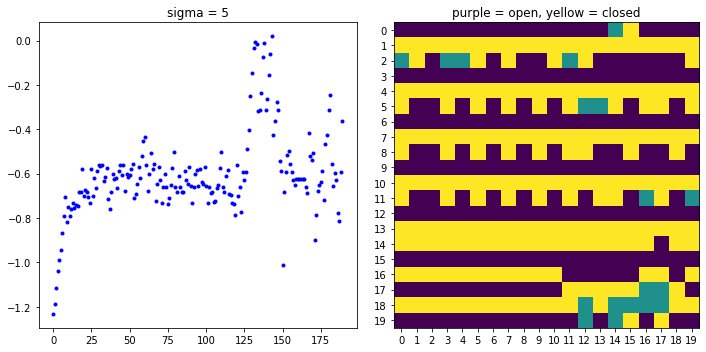

In [8]:
MODE = "row"
GRID_SIZE = 20
ORIENTATIONS = [[-1, 0], [0, 1], [1, 0], [0, -1]]

grid = np.zeros((GRID_SIZE, GRID_SIZE), dtype="int8")

# -- start with a random location.
start_position = np.random.randint(0, GRID_SIZE, size=2)
start_orientation = wrap_around(start_position + np.random.permutation(ORIENTATIONS)[0], GRID_SIZE)

# -- apply start location
grid[tuple(start_position)] = -1
grid[tuple(start_orientation)] = 1

subgrid, index_grid = get_subgrid(grid, start_position)

y_decision = []
STEPS = 900

for i in range(STEPS):
    # 1. find space which contain an "open" cell, those with value "-1' in the subgrid
    available_positions = find_spaces(subgrid, 0)

    # 2. if selecting from subgrid, we need to get the indices which correspond with the global grid.
    available_positions = np.array([lookup(index_grid, space) for space in available_positions])

    # 3. find all adjacent spaces, for each 'open' cell, and wrap around if need be
    adjacent_spaces = find_adjacent(available_positions, GRID_SIZE)

    # 4. check if they are empty or have the value '0'
    available_orientations = np.array([check_availability(o, grid) for o in adjacent_spaces])

    # -- for every position there should be an entry for orientations
    assert available_positions.shape[0] == available_orientations.shape[0]

    # 7. make all combinations of positions and orientations
    available_options = []
    
    for position, orientations in zip(available_positions, available_orientations):    
        for orientation in orientations:
            available_options.append((position, orientation))

    # -- generate build options, 7x7 grids.. they should still be rotated?
    build_options = []

    for position, orientation in available_options:
        temp_grid = grid.copy()

        temp_grid[tuple(position)] = -1
        temp_grid[tuple(orientation)] = 1

        build_option, _ = get_subgrid(temp_grid, position)
        build_options.append(build_option)

    # 8. classify all options and build
    if len(build_options) > 0:
        y_hat = classifier.decision_function(np.array(build_options))
        
        # calculate the distances from the means of the row or random
        distance_to_mean = np.abs(y_hat) - row_mean if MODE == "row" else np.abs(y_hat) - random_mean

        # closest to the mean.
        i = np.argmin(distance_to_mean) 
        position, orientation = available_options[i]

        grid[tuple(position)] = -1
        grid[tuple(orientation)] = 1

        # -- update subgrid for next round
        subgrid, index_grid = get_subgrid(grid, position)
        y_decision.append(y_hat[i])
    else:
        print(f"Done at round {i}")
        break

# -- print building pattern

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].scatter(np.arange(0, len(y_decision)), y_decision, marker=".", c="b")
axs[0].set_title("sigma = 5")

axs[1].imshow(grid)
axs[1].set_title("purple = open, yellow = closed")
axs[1].set_xticks(np.arange(0, GRID_SIZE))
axs[1].set_yticks(np.arange(0, GRID_SIZE))

plt.tight_layout()
plt.show()